In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext lab_black

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from utils.dataloader import get_train_test_loaders, get_cv_train_test_loaders
from utils.model import CustomVGG
from utils.helper import train, evaluate, predict_localize
from utils.constants import NEG_CLASS

## Parameters

In [3]:
data_folder = "Data"
subset_name = "toothbrush"
data_folder = os.path.join(data_folder, subset_name)

batch_size = 10
target_train_accuracy = 0.98
lr = 0.0001
epochs = 10
class_weight = [1, 2] if NEG_CLASS == 1 else [1, 2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

heatmap_thres = 0.7

# Data

In [4]:
# import os
# import numpy as np
# from PIL import Image
# import torch
# from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
# from torchvision import transforms
# from sklearn.model_selection import train_test_split, StratifiedKFold

# from utils.constants import (
#     GOOD_CLASS_FOLDER,
#     DATASET_SETS,
#     INPUT_IMG_SIZE,
#     IMG_FORMAT,
#     NEG_CLASS,
# )


# class MVTEC_AD_DATASET(Dataset):
#     """
#     Class to load subsets of MVTEC ANOMALY DETECTION DATASET
#     Dataset Link: https://www.mvtec.com/company/research/datasets/mvtec-ad
    
#     Root is path to the subset, for instance, `mvtec_anomaly_detection/leather`
#     """

#     def __init__(self, root):
#         print('[INFO] root: ', root)
#         self.classes = ["Good", "Anomaly"] if NEG_CLASS == 1 else ["Anomaly", "Good"]
#         self.img_transform = transforms.Compose(
#             [transforms.Resize(INPUT_IMG_SIZE), transforms.ToTensor()]
#         )

#         (
#             self.img_filenames,
#             self.img_labels,
#             self.img_labels_detailed,
#         ) = self._get_images_and_labels(root)

#     def _get_images_and_labels(self, root):
#         image_names     = []
#         labels          = []
#         labels_detailed = []

#         for folder in DATASET_SETS:
#             folder = os.path.join(root, folder)
            
#             for class_folder in os.listdir(folder):
#                 IMG_FORMAT = '.jpg'
#                 label = (
#                     1 - NEG_CLASS if class_folder == GOOD_CLASS_FOLDER else NEG_CLASS
#                 )
#                 label_detailed = class_folder

#                 class_folder = os.path.join(folder, class_folder)
#                 class_images = os.listdir(class_folder)
#                 class_images = [
#                     os.path.join(class_folder, image)
#                     for image in class_images
#                     if image.find(IMG_FORMAT) > -1
#                 ]

#                 image_names.extend(class_images)
#                 labels.extend([label] * len(class_images))
#                 labels_detailed.extend([label_detailed] * len(class_images))

#         print(
#             "Dataset {}: N Images = {}, Share of anomalies = {:.3f}".format(
#                 root, len(labels), np.sum(labels) / len(labels)
#             )
#         )
        
#         return image_names, labels, labels_detailed

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_fn = self.img_filenames[idx]
#         label = self.img_labels[idx]
#         img = Image.open(img_fn)
#         img = self.img_transform(img)
#         label = torch.as_tensor(label, dtype=torch.long)
#         return img, label


# def get_train_test_loaders(root, batch_size, test_size=0.2, random_state=42):
#     """
#     Returns train and test dataloaders.
#     Splits dataset in stratified manner, considering various defect types.
#     """
#     dataset = MVTEC_AD_DATASET(root=root)

#     train_idx, test_idx = train_test_split(
#         np.arange(dataset.__len__()),
#         test_size=test_size,
#         shuffle=True,
#         stratify=dataset.img_labels_detailed,
#         random_state=random_state,
#     )
#     train_sampler = SubsetRandomSampler(train_idx)
#     test_sampler = SubsetRandomSampler(test_idx)

#     train_loader = DataLoader(
#         dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True
#     )
#     test_loader = DataLoader(
#         dataset, batch_size=batch_size, sampler=test_sampler, drop_last=False
#     )
#     return train_loader, test_loader


In [5]:
train_loader, test_loader = get_train_test_loaders(root=data_folder, batch_size=batch_size, test_size=0.2, random_state=42)

Dataset Data/toothbrush: N Images = 102, Share of anomalies = 0.294


# Model Training

In [6]:
model = CustomVGG()

class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
criterion    = nn.CrossEntropyLoss(weight=class_weight)
optimizer    = optim.Adam(model.parameters(), lr=lr)

# Stored in directory: /home/ili/.cache/torch/hub/checkpoints/vgg16-397923af.pth

In [7]:
model = train(train_loader, model, optimizer, criterion, epochs, device, target_train_accuracy)

Epoch 1/10: Loss = 0.6898, Accuracy = 0.6750
Epoch 2/10: Loss = 0.6466, Accuracy = 0.5125
Epoch 3/10: Loss = 0.5228, Accuracy = 0.8375
Epoch 4/10: Loss = 0.4777, Accuracy = 0.7375
Epoch 5/10: Loss = 0.4077, Accuracy = 0.8500
Epoch 6/10: Loss = 0.4221, Accuracy = 0.8375
Epoch 7/10: Loss = 0.3259, Accuracy = 0.9125
Epoch 8/10: Loss = 0.2668, Accuracy = 0.9125
Epoch 9/10: Loss = 0.2427, Accuracy = 0.9250
Epoch 10/10: Loss = 0.2134, Accuracy = 0.9375


In [8]:
model_path = f"weights/{subset_name}_model.h5"
torch.save(model, model_path)
# model = torch.load(model_path, map_location=device)

# Evaluation

/home/ili/.conda/envs/dev_ili_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Accuracy: 0.9048
Balanced Accuracy: 0.8333



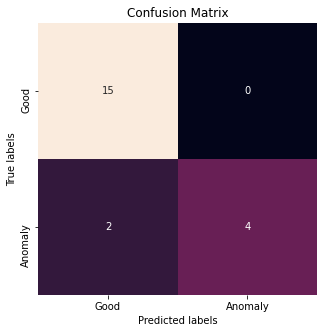

In [9]:
evaluate(model, test_loader, device)

# Visualization

/home/ili/.conda/envs/dev_ili_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


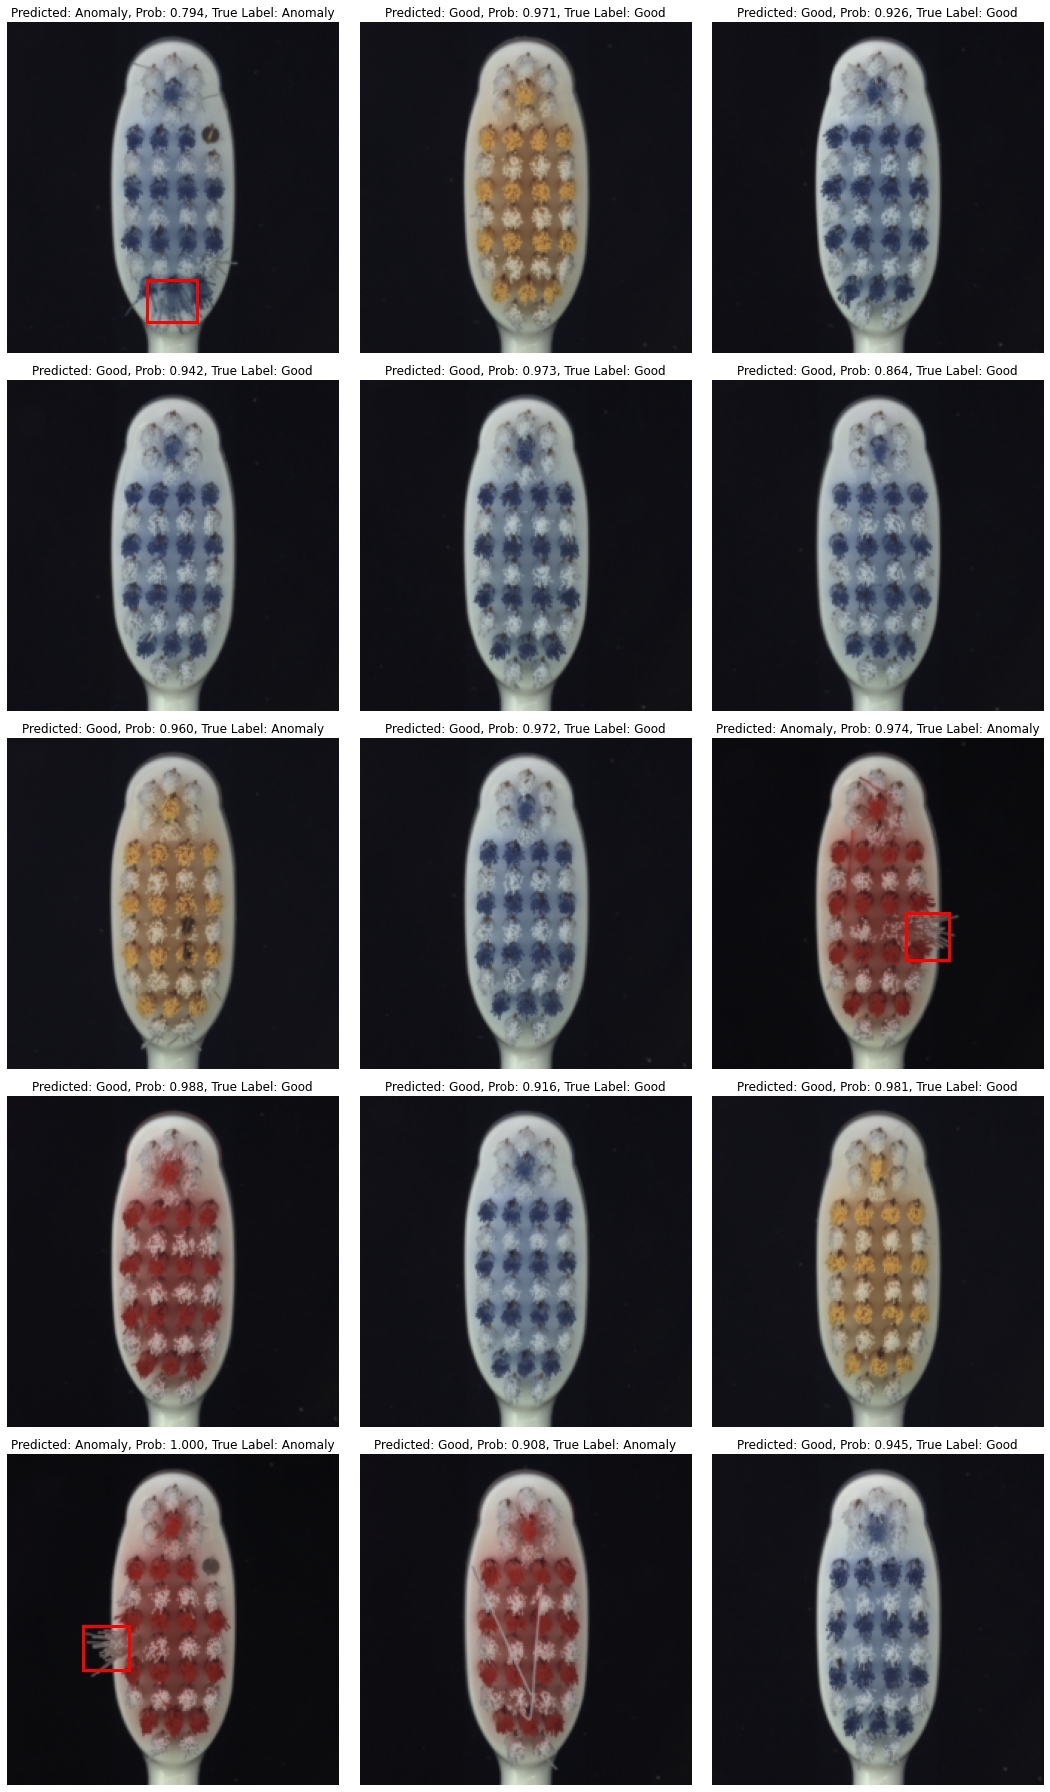

In [10]:
predict_localize(model, test_loader, device, thres=0.8, n_samples=15, show_heatmap=False)